In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

In [6]:

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5

IMG_CHANNELS = 3

In [7]:
IMG_PATH = r'C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\train\images'
LABELS_PATH = r'C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\train\labels'
IMG_PATH_TEST = r'C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\test\images'
LABELS_PATH_TEST = r'C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\test\labels'

In [8]:

print("Image Path:", IMG_PATH)
print("Labels Path:", LABELS_PATH)
print("Test Image Path:", IMG_PATH_TEST)
print("Test Labels Path:", LABELS_PATH_TEST)

Image Path: C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\train\images
Labels Path: C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\train\labels
Test Image Path: C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\test\images
Test Labels Path: C:\Users\athot\OneDrive\Desktop\major_project\oil-spill\test\labels


In [9]:
import os

try:
    IMG_IDS = sorted(os.listdir(IMG_PATH))
    LABELS_IDS = sorted(os.listdir(LABELS_PATH))
    IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
    LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check that the directory exists.")

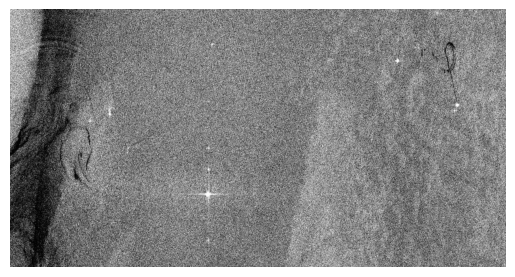

Randomly selected image: img_0006.jpg


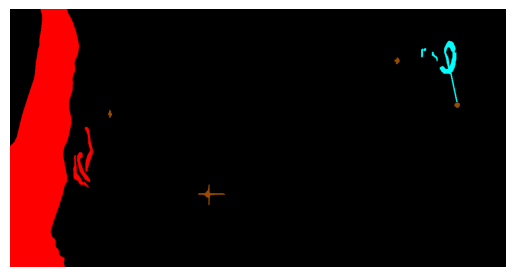

Randomly selected mask: img_0006.png


In [10]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [11]:

COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [12]:
train_images = []
train_masks = []

test_images = []
test_masks = []


In [13]:

for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [01:06<00:00, 14.99it/s]


In [14]:

train_masks.shape

(1002, 256, 256, 1)

In [15]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


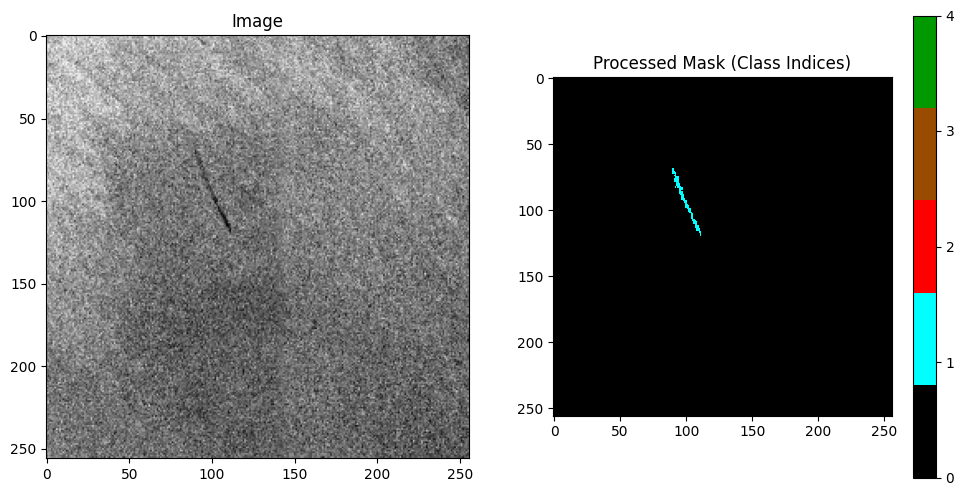

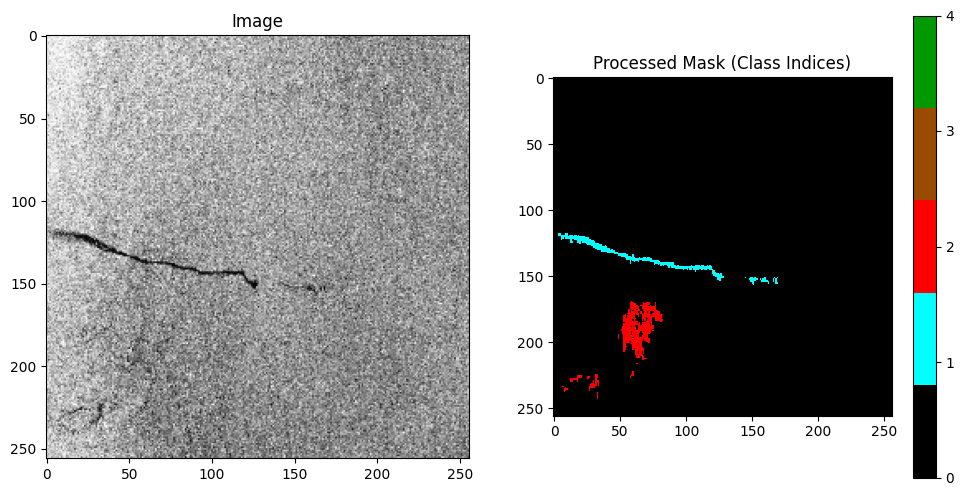

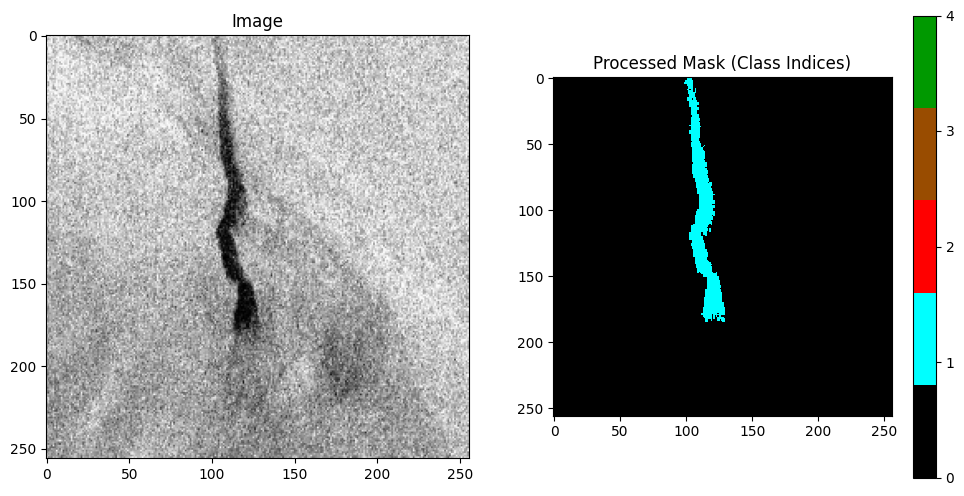

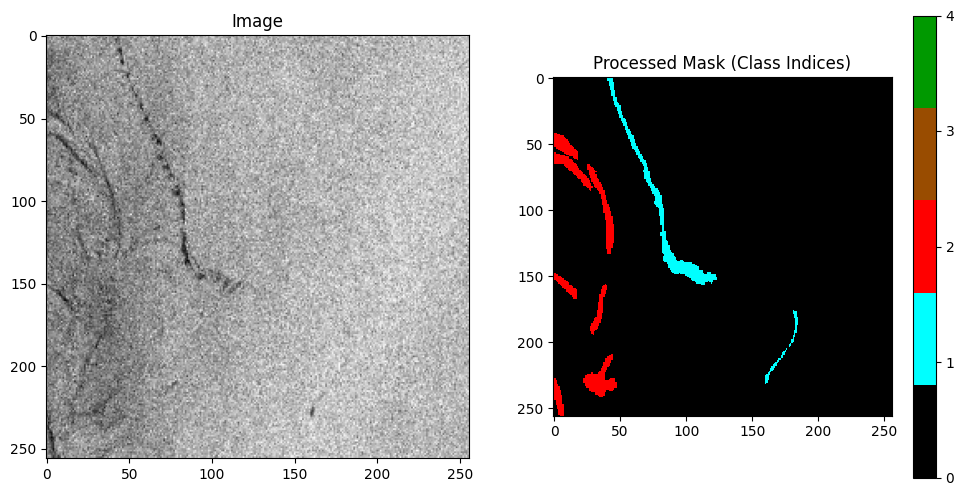

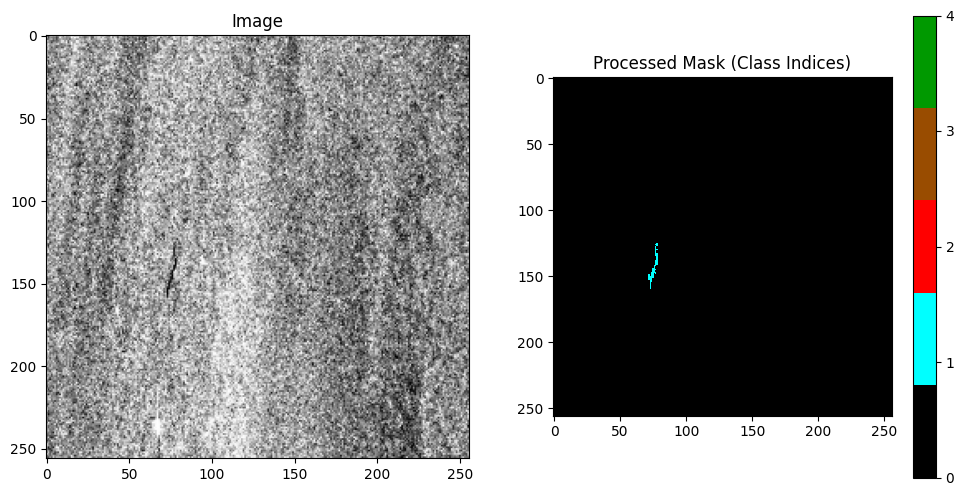

In [16]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [17]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:06<00:00, 17.94it/s]


In [18]:
test_masks.shape

(110, 256, 256, 1)

In [19]:


unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


In [20]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [21]:

print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [22]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


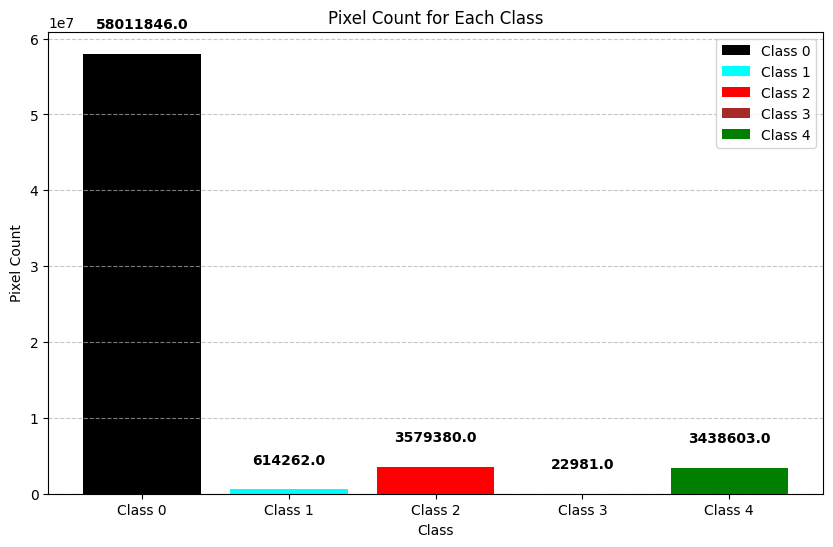

In [23]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [24]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [25]:
def UNet(input_shape, IMG_CLASSES): 

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [26]:

unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,173 (7.40 MB)

 Trainable params: 1,941,173 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Clear previous sessions
tf.keras.backend.clear_session()

# Compile the model
unet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

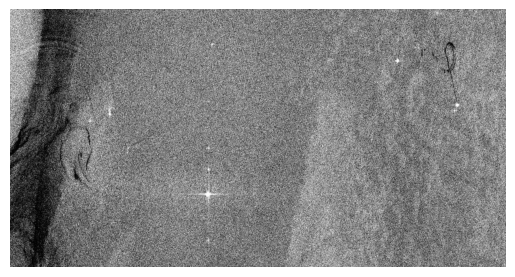

Randomly selected image: img_0006.jpg


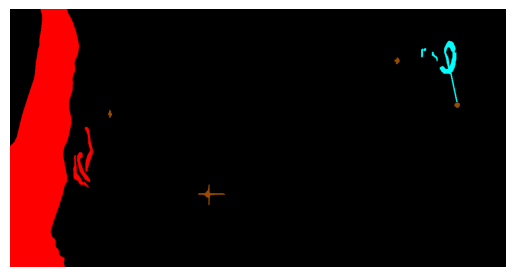

Randomly selected mask: img_0006.png


In [28]:

# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [29]:
#unet_model.compile()
unet_history = unet_model.fit(train_images, train_masks,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.5483 - loss: 1.0457 - val_accuracy: 0.8967 - val_loss: 0.4569
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8794 - loss: 0.4900 - val_accuracy: 0.9071 - val_loss: 0.3241
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8809 - loss: 0.4074 - val_accuracy: 0.9124 - val_loss: 0.3040
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8921 - loss: 0.3354 - val_accuracy: 0.9338 - val_loss: 0.2551
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.8984 - loss: 0.3109 - val_accuracy: 0.9315 - val_loss: 0.2339
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8814 - loss: 0.3249 - val_accuracy: 0.9265 - val_loss: 0.2110
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8999 - loss: 0.2998 - val_accuracy: 0.9389 - val_loss: 0.1986
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9123 - loss: 0.2626 - val_accuracy: 0.

In [2]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

NameError: name 'unet_history' is not defined

In [ ]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    
    # Test Image 
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()

In [ ]:
prediction_unet = unet_model.predict(test_images)

print(test_masks.shape)
print(prediction_unet.shape)

In [ ]:
# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
unet_model.save(r"C:\Users\athot\OneDrive\Desktop\major_project\U_net_mine.h5")